# 6. Linear Regression with Multiple Regressors

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_excel("data/replication/Replication Data/caschool.xlsx")
df.head()

F:\miniconda3\envs\py\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,testscr,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024


## Omitted Variable Bias

In [3]:
df.columns

Index(['Observation Number', 'dist_cod', 'county', 'district', 'gr_span',
       'enrl_tot', 'teachers', 'calw_pct', 'meal_pct', 'computer', 'testscr',
       'comp_stu', 'expn_stu', 'str', 'avginc', 'el_pct', 'read_scr',
       'math_scr'],
      dtype='object')

Students who are still learning English might perform worse on standardized tests than
native English speakers.

In [4]:
df['str'].corr(df["el_pct"])

np.float64(0.18764236785449276)

<Axes: xlabel='str', ylabel='el_pct'>

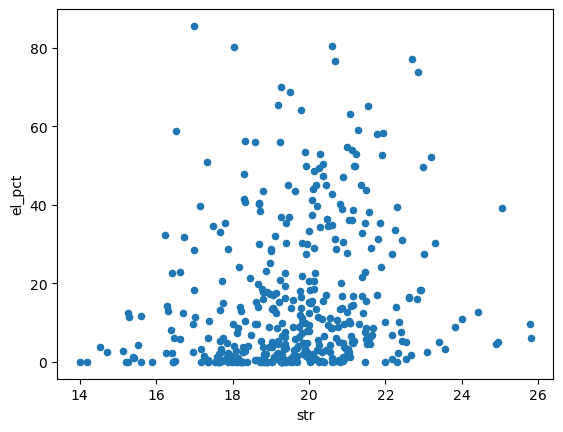

In [5]:
df.plot('str','el_pct', kind = 'scatter')

This small but positive correlation suggests that districts with more
English learners tend to have a higher student–teacher ratio (larger classes)

It is plausible that students who are still learning English will do
worse on standardized tests than native English speakers

**Percentage of English learners**: 
correlated with student teacher ratio ✅  
determinant of test score ✅  
$ \therefore$ omitting it leads to ommited variable bias

**Time of day of the test**:   
uncorrelated with student teacher ratio ❌  
determinant of test score ✅    
$ \therefore$ omitting it does not lead to ommited variable bias

**Parking lot space per pupil**: 
(the area of the teacher parking lot divided by the number of students)  
  
correlated with student teacher ratio ✅  
determinant of test score ❌  
$ \therefore$ omitting it does not lead to ommited variable bias

In [6]:
df['el_pct']

0       0.000000
1       4.583333
2      30.000002
3       0.000000
4      13.857677
         ...    
415     5.995935
416     4.726101
417    24.263039
418     2.970297
419     5.005624
Name: el_pct, Length: 420, dtype: float64

### Addressing ommited variable bias by dividing data into groups

In [7]:
bins = [0, 1.9, 8.8, 23, float('inf')]
labels = ['< 1.9', '1.9-8.8', '8.8-23', '> 23']

df['el_pct_category'] = pd.cut(df['el_pct'], bins=bins, labels=labels, right = False)
df.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,testscr,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr,el_pct_category
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000,< 1.9
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024,1.9-8.8
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024,> 23
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000,< 1.9
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024,8.8-23


In [8]:
df['D'] = (df['str'] < 20).astype(int)
df['D'] = df['D'].map({0: '>= 20', 1: '< 20'})
df.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,testscr,comp_stu,expn_stu,str,avginc,el_pct,read_scr,math_scr,el_pct_category,D
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000,< 1.9,< 20
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024,1.9-8.8,>= 20
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024,> 23,< 20
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000,< 1.9,< 20
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024,8.8-23,< 20


In [9]:
grouped = df.groupby(['D', 'el_pct_category'], observed=True)

In [10]:
grouped.agg(
    avg_test_score=('testscr', 'mean'),
    n=('testscr', 'size')
).reset_index()

,D,el_pct_category,avg_test_score,n
0,< 20,< 1.9,664.470391,76
1,< 20,1.9-8.8,665.157029,64
2,< 20,8.8-23,654.882406,54
3,< 20,> 23,636.730687,44
4,>= 20,< 1.9,665.370377,27
5,>= 20,1.9-8.8,661.828405,44
6,>= 20,8.8-23,649.713007,50
7,>= 20,> 23,634.836888,61


In [11]:
mean_crosstab = pd.crosstab(df['D'], df['el_pct_category'],
                            values=df['testscr'], aggfunc='mean')
mean_crosstab

el_pct_category,< 1.9,1.9-8.8,8.8-23,> 23
D,,,,
< 20,664.470391,665.157029,654.882406,636.730687
>= 20,665.370377,661.828405,649.713007,634.836888


In [12]:
count_crosstab = pd.crosstab(df['D'], df['el_pct_category'])
count_crosstab

el_pct_category,< 1.9,1.9-8.8,8.8-23,> 23
D,,,,
< 20,76,64,54,44
>= 20,27,44,50,61


In [13]:
averageScoreSmallRatio = df[df["D"] == '< 20']['testscr'].mean()
averageScoreSmallRatio

np.float64(657.3512591193704)

In [14]:
averageScorelargeRatio = df[df["D"] == '>= 20']['testscr'].mean()
averageScorelargeRatio

np.float64(649.9788489708534)

In [15]:
averageScoreSmallRatio - averageScorelargeRatio

np.float64(7.3724101485170195)

In [16]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(df[df["D"] == '>= 20']['testscr'],
                                   df[df["D"] == '< 20']['testscr'], equal_var = False)
t_stat, p_value

(np.float64(-4.042581848666498), np.float64(6.332554425244588e-05))

null hypothesis that the mean test score is the same in the two
groups is rejected at the 1% significance level

#### across all districts, 
those with a low student–teacher ratio have, on average, a test score 7.4 points higher than those with a high student–teacher ratio. The t-statistic of 4.04 indicates that this difference is statistically significant.

#### Differences by Percentage of English Learners

<= 1.9%:

Average test score for districts with low student–teacher ratio: 664.5  
Average test score for districts with high student–teacher ratio: 665.4  
Difference in test scores: -0.9  
t-statistic: -0.30

1.9–8.8%:

Average test score for districts with low student–teacher ratio: 665.2   
Average test score for districts with high student–teacher ratio: 661.8  
Difference in test scores: 3.3  
t-statistic: 1.13

8.8–23.0%:

Average test score for districts with low student–teacher ratio: 654.9  
Average test score for districts with high student–teacher ratio: 649.7  
Difference in test scores: 5.2  
t-statistic: 1.72  

 23.0%:

Average test score for districts with low student–teacher ratio: 636.7  
Average test score for districts with high student–teacher ratio: 634.8  
Difference in test scores: 1.9  
t-statistic: 0.68

Overall Effect: The overall difference in test scores suggests that districts with low student–teacher ratios tend to have higher test scores.  

By Quartile: When breaking down by the percentage of English learners, the differences in test scores are smaller and less consistent. This suggests that the effect of student–teacher ratio on test scores is influenced by the percentage of English learners in the district.

#### Why the Differences?

Districts with more English learners tend to have both higher student–teacher ratios and lower test scores.  
The large overall difference in test scores (7.4 points) is partly due to the fact that districts with fewer English learners (who generally have higher test scores) also tend to have lower student–teacher ratios.  
When you control for the percentage of English learners, the differences in test scores between low and high student–teacher ratio districts are smaller. This indicates that the percentage of English learners is an important factor that affects test scores.

## Multiple Regression

In [17]:
model = smf.ols("testscr ~ str", data = df).fit(cov_type='HC2')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     19.13
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           1.55e-05
Time:                        14:46:53   Log-Likelihood:                -1822.2
No. Observations:                 420   AIC:                             3648.
Df Residuals:                     418   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    698.9330     10.400     67.206      0.000     678.550     719.316
str           -2.2798      0.521     -4.373      0.000      -3.302      -1.258
==============================================================================
Omnibus:                        5.390   Durbin-Watson:                   0.129
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                3.589
Skew:                          -0.012   Prob(JB):                        0.166
Kurtosis:                       2.548   Cond. No.                         207.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [18]:
model.rsquared

np.float64(0.051240095079614356)

Student Teacher Ratio explains only 5% of the variation in test scores

In [19]:
model2 = smf.ols("testscr ~ str + el_pct", data = df).fit(cov_type='HC2')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     222.8
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           1.56e-66
Time:                        14:46:53   Log-Likelihood:                -1716.6
No. Observations:                 420   AIC:                             3439.
Df Residuals:                     417   BIC:                             3451.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    686.0322      8.754     78.365      0.000     668.874     703.190
str           -1.1013      0.434     -2.537      0.011      -1.952      -0.250
el_pct        -0.6498      0.031    -20.888      0.000      -0.711      -0.589
==============================================================================
Omnibus:                        0.631   Durbin-Watson:                   0.686
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.550
Skew:                           0.088   Prob(JB):                        0.760
Kurtosis:                       3.024   Cond. No.                         301.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

coefficient of str became half (-1.10 vs -2.28) cuz it controls for english percentage

among
schools within the same quartile of percentage of English learners, the difference in test
scores between schools with a high vs. a low student–teacher ratio is less than the difference if one does not hold constant the percentage of English learners.

In [20]:
math.sqrt(model2.ssr/(model2.nobs - 3))

14.4644849557101

standard error decreased, predictions are more precise

In [21]:
model2.rsquared

np.float64(0.4264313614327716)

when EL_pct is added to the regression, 42.6% of the variation in test scores is explained

In [22]:
model2.rsquared_adj

np.float64(0.4236804327106266)

n is large and only two regressors appear, difference between $R^2$ and $\bar{R}^2$ is small

## Multicollinearity

🚧 Under Construction